# Add libs


In [1]:
import random
import string
import numpy as np
import tensorflow as tf
import pandas as pd
import string 

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Prepare data

In [2]:
mergeddata = pd.read_csv("datamerge.csv")
mergeddata = mergeddata[["latitude","longitude","address","zip","city","mappage","maprow",
                         "mapcol","dir","neighborhd","cross_st", "cmplx","market_area","community"]]
mergeddata = mergeddata.drop_duplicates().fillna(0).reset_index(drop="True")
n = mergeddata.shape[0]-1


mergeddata.mapcol = mergeddata.mapcol.str.lower().map({string.ascii_lowercase[i]:i for i in range(10)}).fillna(0)
mergeddata.dir = mergeddata.dir.astype(str)
mergeddata.neighborhd = mergeddata.neighborhd.astype(str)
mergeddata.cross_st = mergeddata.cross_st.astype(str)
mergeddata.cmplx = mergeddata.cmplx.astype(str)
mergeddata.community = mergeddata.community.astype(str)
mergeddata.market_area = mergeddata.market_area.astype(str)
mergeddata.maprow = pd.to_numeric(mergeddata.maprow, errors='coerce').fillna(0)
mergeddata.mappage = pd.to_numeric(mergeddata.mappage, errors='coerce').fillna(-100)
mergeddata.mappage = mergeddata.mappage + (mergeddata.maprow*10 + mergeddata.mapcol) /100





# Set up Tensorflow


In [3]:
sess = tf.Session()
# market_area","community"
# test
test_address = tf.sparse_placeholder( dtype=tf.string)
test_city = tf.sparse_placeholder( dtype=tf.string)
test_neighborhd = tf.sparse_placeholder( dtype=tf.string)
test_cross_st = tf.sparse_placeholder( dtype=tf.string)
test_dir = tf.sparse_placeholder( dtype=tf.string)
test_cmplx = tf.sparse_placeholder( dtype=tf.string)
test_community = tf.sparse_placeholder( dtype=tf.string)
test_market_area = tf.sparse_placeholder( dtype=tf.string)
test_zip = tf.placeholder(shape=[None, 1], dtype=tf.float32)
test_mappage = tf.placeholder(shape=[None, 1], dtype=tf.float32)



# ref
ref_address = tf.sparse_placeholder(dtype=tf.string)
ref_city = tf.sparse_placeholder(dtype=tf.string)
ref_neighborhd = tf.sparse_placeholder(dtype=tf.string)
ref_dir = tf.sparse_placeholder( dtype=tf.string)
ref_cmplx = tf.sparse_placeholder( dtype=tf.string)
ref_community = tf.sparse_placeholder( dtype=tf.string)
ref_market_area = tf.sparse_placeholder( dtype=tf.string)
ref_cross_st = tf.sparse_placeholder( dtype=tf.string)
ref_zip = tf.placeholder(shape=[None, n], dtype=tf.float32)
ref_mappage = tf.placeholder(shape=[None, n], dtype=tf.float32)                          


# Distances


In [4]:
zip_dist = tf.square(tf.subtract(ref_zip, test_zip))
mappage_dist = tf.square(tf.subtract(ref_mappage, test_mappage))
address_dist = tf.edit_distance(test_address, ref_address, normalize=True)
city_dist = tf.edit_distance(test_city, ref_city, normalize=True)
neighborhd_dist = tf.edit_distance(test_neighborhd, ref_neighborhd, normalize=True)
cross_st_dist = tf.edit_distance(test_cross_st, ref_cross_st, normalize=True)
dir_dist = tf.edit_distance(test_dir, ref_dir, normalize=True)
cmplx_dist = tf.edit_distance(test_cmplx, ref_cmplx, normalize=True)
community_dist = tf.edit_distance(test_cmplx, ref_community, normalize=True)
market_area_dist = tf.edit_distance(test_market_area, ref_market_area, normalize=True)

# Similarities

In [5]:
zip_max = tf.gather(tf.squeeze(zip_dist), tf.argmax(zip_dist, 1))
zip_min = tf.gather(tf.squeeze(zip_dist), tf.argmin(zip_dist, 1))
zip_sim = tf.div(tf.subtract(zip_max, zip_dist), tf.subtract(zip_max, zip_min))

mappage_max = tf.gather(tf.squeeze(mappage_dist), tf.argmax(mappage_dist, 1))
mappage_min = tf.gather(tf.squeeze(mappage_dist), tf.argmin(mappage_dist, 1))
mappage_sim = tf.div(tf.subtract(mappage_max, mappage_dist), tf.subtract(mappage_max, mappage_min))


address_sim = tf.subtract(1., address_dist)
city_sim = tf.subtract(1., city_dist)
dir_sim = tf.subtract(1., dir_dist)
neighborhd_sim = tf.subtract(1., neighborhd_dist)
cross_st_sim = tf.subtract(1., cross_st_dist)
cmplx_sim = tf.subtract(1., cmplx_dist)
community_sim = tf.subtract(1., community_dist)
market_area_sim = tf.subtract(1., mappage_dist)

# Weights

In [6]:
address_weight = 0.2
city_weight = 0.3
mappage_weight = 0.1
dir_weight = 0.02
neighborhd_weight = 0.02
cross_st_weight = 0.02
cmplx_weight = 0.02
market_area_weight = 0.02
community_weight = 0.02

zip_weight = 1. - (address_weight + city_weight + mappage_weight)

weighted_sim1 = tf.add(tf.transpose(tf.multiply(address_weight, address_sim)),
                      tf.multiply(zip_weight, zip_sim))
                      
weighted_sim2 = tf.add(tf.transpose(tf.multiply(city_weight, city_sim)), weighted_sim1)

weighted_sim3 = tf.add(tf.multiply(zip_weight, zip_sim), weighted_sim2)

weighted_sim4 = tf.add(tf.transpose(tf.multiply(dir_weight, dir_sim)), weighted_sim3)

weighted_sim5 = tf.add(tf.transpose(tf.multiply(neighborhd_weight, neighborhd_sim)), weighted_sim4)

weighted_sim6 = tf.add(tf.transpose(tf.multiply(cross_st_weight, cross_st_sim)), weighted_sim5)

weighted_sim7 = tf.add(tf.transpose(tf.multiply(cmplx_weight, cmplx_sim)), weighted_sim6)

weighted_sim8 = tf.add(tf.transpose(tf.multiply(market_area_weight, market_area_sim)), weighted_sim7)

weighted_sim9 = tf.add(tf.transpose(tf.multiply(community_weight, community_sim)), weighted_sim8)


top_match_index = tf.argmax(weighted_sim9, 1)

# MISC

In [8]:
def sparse_from_word_vec(word_vec):
    num_words = len(word_vec)
    indices = [[xi, 0, yi] for xi,x in enumerate(word_vec) for yi,y in enumerate(x)]
    chars = list(''.join(word_vec))
    # Now we return our sparse vector
    return(tf.SparseTensorValue(indices, chars, [num_words,1,1]))

def getTestSet(testNumber, maxN):
    # test 
    test = {}
    test["address"] = mergeddata.address[testNumber] 
    test["zip"] = mergeddata.zip[testNumber]
    test["city"] = mergeddata.city[testNumber]
    test["latitude"] = mergeddata.latitude[testNumber] 
    test["longitude"] = mergeddata.longitude[testNumber]
    test["mappage"] = mergeddata.mappage[testNumber]
    test["dir"] = mergeddata.dir[testNumber]
    test["neighborhd"] = mergeddata.neighborhd[testNumber]
    test["cross_st"] = mergeddata.cross_st[testNumber]
    test["cmplx"] = mergeddata.cmplx[testNumber]
    test["market_area"] = mergeddata.market_area[testNumber]
    test["community"] = mergeddata.community[testNumber]

    # ref
    ref = {}
    ref["address"] = list(mergeddata.address[:testNumber]) + list((mergeddata.address[(testNumber+1):maxN])) 
    ref["zip"] = list(mergeddata.zip[:testNumber]) + list((mergeddata.zip[(testNumber+1):maxN]))
    ref["city"] = list(mergeddata.city[:testNumber]) + list((mergeddata.city[(testNumber+1):maxN]))
    ref["latitude"] = list(mergeddata.latitude[:testNumber]) + list((mergeddata.latitude[(testNumber+1):maxN]))
    ref["longitude"] = list(mergeddata.longitude[:testNumber]) + list((mergeddata.longitude[(testNumber+1):maxN]))   
    ref["mappage"] = list(mergeddata.mappage[:testNumber]) + list((mergeddata.mappage[(testNumber+1):maxN]))
    ref["dir"] = list(mergeddata.dir[:testNumber]) + list((mergeddata.dir[(testNumber+1):maxN]))
    ref["neighborhd"] = list(mergeddata.neighborhd[:testNumber]) + list((mergeddata.neighborhd[(testNumber+1):maxN]))
    ref["cross_st"] = list(mergeddata.cross_st[:testNumber]) + list((mergeddata.cross_st[(testNumber+1):maxN]))
    ref["cmplx"] = list(mergeddata.cross_st[:testNumber]) + list((mergeddata.cross_st[(testNumber+1):maxN]))
    ref["market_area"] = list(mergeddata.market_area[:testNumber]) + list((mergeddata.market_area[(testNumber+1):maxN]))
    ref["community"] = list(mergeddata.community[:testNumber]) + list((mergeddata.community[(testNumber+1):maxN]))
    
    return (test, ref)

def customDistance(test_lat, test_long, ref_lat, ref_long):
    diff_lat = abs(float(test_lat) - float(ref_lat))
    diff_long = abs(float(test_long) - float(ref_long))
    return ( (diff_lat + diff_long)/2.0 )

from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


# Run Tensorflow

In [12]:

scores = []

for i in range(30):
    test, ref = getTestSet(i, n+1)

    reference_addresses = ref["address"]
    reference_zips = np.array([ref["zip"]])
    reference_mappages = np.array([ref["mappage"]])
    reference_cities = ref["city"]
    reference_dir = ref["dir"]
    reference_neighborhd = ref["neighborhd"]
    reference_cross_st = ref["cross_st"]
    reference_cmplx = ref["cmplx"]
    reference_market_area = ref["market_area"]
    reference_community = ref["community"]
    

    
    sparse_ref_set = sparse_from_word_vec(reference_addresses)
    sparse_ref_cities = sparse_from_word_vec(reference_cities)
    sparse_ref_dir = sparse_from_word_vec(reference_dir)
    sparse_ref_neighborhd = sparse_from_word_vec(reference_neighborhd)
    sparse_ref_cross_st = sparse_from_word_vec(reference_cross_st)
    sparse_ref_cmplx = sparse_from_word_vec(reference_cmplx)
    sparse_ref_market_area = sparse_from_word_vec(reference_market_area)
    sparse_ref_community = sparse_from_word_vec(reference_community)
    
    test_address_entry = test["address"]
    test_zip_entry = [[test["zip"]]]
    test_mappage_entry = [[test["mappage"]]]
    test_city_entry = test["city"]
    test_dir_entry = test["dir"]
    test_neighborhd_entry = test["neighborhd"]
    test_cross_st_entry = test["cross_st"]
    test_cmplx_entry = test["cmplx"]
    test_market_area_entry = test["market_area"]
    test_community_entry = test["community"]

    # Create sparse address vectors
    test_address_repeated = [test_address_entry] * n
    sparse_test_set = sparse_from_word_vec(test_address_repeated)
    test_city_repeated = [test_city_entry] * n
    sparse_test_city = sparse_from_word_vec(test_city_repeated)
    test_dir_repeated = [test_city_entry] * n
    sparse_test_dir = sparse_from_word_vec(test_dir_repeated)
    test_neighborhd_repeated = [test_neighborhd_entry] * n
    sparse_test_neighborhd = sparse_from_word_vec(test_neighborhd_repeated)
    test_cross_st_repeated = [test_cross_st_entry] * n
    sparse_test_cross_st = sparse_from_word_vec(test_cross_st_repeated)
    test_cmplx_repeated = [test_cmplx_entry] * n
    sparse_test_cmplx = sparse_from_word_vec(test_cmplx_repeated)
    test_market_area_repeated = [test_market_area_entry] * n
    sparse_test_market_area = sparse_from_word_vec(test_market_area_repeated)
    test_community_repeated = [test_community_entry] * n
    sparse_test_community = sparse_from_word_vec(test_community_repeated)

    
    feeddict={test_address: sparse_test_set,
               test_zip: test_zip_entry,
               test_mappage: test_mappage_entry,
               test_city: sparse_test_city,
               test_dir: sparse_test_dir,
               test_neighborhd : sparse_test_neighborhd,
               test_cross_st : sparse_test_cross_st,
               test_cmplx : sparse_test_cmplx,
               test_market_area: sparse_test_cmplx,
               test_community: sparse_test_community,
               ref_address: sparse_ref_set,
               ref_zip: reference_zips,
               ref_mappage: reference_mappages,
               ref_city: sparse_ref_cities,
               ref_dir: sparse_ref_dir,
               ref_neighborhd: sparse_ref_neighborhd,
               ref_cross_st: sparse_ref_cross_st,
               ref_cmplx: sparse_ref_cmplx,
               ref_market_area: sparse_ref_market_area,
               ref_community: sparse_ref_community}
    best_match = sess.run(top_match_index, feed_dict=feeddict)
    
    best_match = best_match[0]
    
    
    best_street = reference_addresses[int(best_match)]
    best_city = reference_cities[int(best_match)]
    best_zip = reference_zips[0][best_match]
    print test_city_entry
    [[test_zip_]] = test_zip_entry
    print('Address: ' + str(test_city_entry) + "," + str(test_address_entry) + ', ' + str(test_zip_)) + ', ' + str(test["latitude"])
    print('Match  : ' + str(best_city) + ','+ str(best_street) + ','  + str(best_zip))+ ', ' + str(ref["latitude"][int(best_match)])
    scores.append( haversine(test["longitude"],
                         test["latitude"],
                         ref["longitude"][int(best_match)],
                         ref["latitude"][int(best_match)]))
                     
print "%s: %s ± %s"%("neg_mean_absolute_error (km)", round(np.mean(scores),4), round(np.std(scores),4))

                     

SAN DIEGO
Address: SAN DIEGO,17725 BELLECHASE CIR, 92128, 33.03666
Match  : SAN DIEGO,16810 BLUE CRANE WAY,92127, 33.01391
ESCONDIDO
Address: ESCONDIDO,304 HIDDEN TRAILS RD, 92027, 33.14431
Match  : ESCONDIDO,304 HIDDEN TRAILS RD,92027, 33.14431
ESCONDIDO
Address: ESCONDIDO,304 HIDDEN TRAILS RD, 92027, 33.14431
Match  : ESCONDIDO,304 HIDDEN TRAILS RD,92027, 33.14431
SAN DIEGO
Address: SAN DIEGO,1876 ELM AVE., 92154, 32.58095
Match  : SAN DIEGO,3610 PALM AVE,92154, 32.58405
SAN DIEGO
Address: SAN DIEGO,877 ISLAND AVE, 92101, 32.71008
Match  : SAN DIEGO,877 ISLAND AVE,92101, 32.71011
SAN DIEGO
Address: SAN DIEGO,877 ISLAND AVE, 92101, 32.71008
Match  : SAN DIEGO,877 ISLAND AVE,92101, 32.71008
SAN DIEGO
Address: SAN DIEGO,877 ISLAND AVE, 92101, 32.71008
Match  : SAN DIEGO,1225 ISLAND AVE,92101, 32.71001
SAN DIEGO
Address: SAN DIEGO,877 ISLAND AVE, 92101, 32.71008
Match  : SAN DIEGO,1225 ISLAND AVE,92101, 32.71001
SAN DIEGO
Address: SAN DIEGO,877 ISLAND AVE, 92101, 32.71011
Match  : SAN DI

In [10]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

Text(0.5,1,'Error distribution')

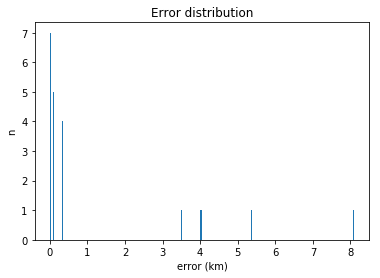

In [11]:
plt.hist(scores,200)
plt.xlabel('error (km)')
plt.ylabel('n')
plt.title('Error distribution')

# Batch mode


In [144]:
scores = []

# change datamerge.csv to your input file
batchinput = pd.read_csv("datamerge.csv")
batchinput = batchinput[["latitude","longitude","address","zip","city","mappage"]]
batchinput = batchinput.drop_duplicates().fillna(0).reset_index(drop="True")
batchinput.mappage = pd.to_numeric(batchinput.mappage, errors='coerce').fillna(-100)

# comment if test has been working
for i in range(10):
# uncomment for full run - may take some time    
#for i in range(batchinput.shape[0]):    
    test, ref = getTestSet(i, n+1)

    reference_addresses = ref["address"]
    reference_zips = np.array([ref["zip"]])
    reference_mappages = np.array([ref["mappage"]])
    reference_cities = ref["city"]
    
    print ("----")
    sparse_ref_set = sparse_from_word_vec(reference_addresses)
    sparse_ref_cities = sparse_from_word_vec(reference_cities)
    test_address_entry = batchinput.address[i]
    test_zip_entry = [[batchinput.zip[i]]]
    test_mappage_entry = [[batchinput.mappage[i]]]
    test_city_entry = batchinput.city[i]

    # Create sparse address vectors
    test_address_repeated = [test_address_entry] * n
    sparse_test_set = sparse_from_word_vec(test_address_repeated)
    test_city_repeated = [test_city_entry] * n
    sparse_test_city = sparse_from_word_vec(test_city_repeated)

    feeddict={test_address: sparse_test_set,
               test_zip: test_zip_entry,
               test_mappage: test_mappage_entry,
               test_city: sparse_test_city,
               ref_address: sparse_ref_set,
               ref_zip: reference_zips,
               ref_mappage: reference_mappages,
               ref_city: sparse_ref_cities}
    best_match = sess.run(top_match_index, feed_dict=feeddict)
    best_street = reference_addresses[int(best_match)]
    best_city = reference_cities[int(best_match)]
    [best_zip] = reference_zips[0][best_match]
    [[test_zip_]] = test_zip_entry
    print('Address: ' + str(test_city_entry) + "," + str(test_address_entry) + ', ' + str(test_zip_)) + ', ' + str(test["latitude"])
    print('Match  : ' + str(best_city) + ','+ str(best_street) + ','  + str(best_zip))+ ', ' + str(ref["latitude"][int(best_match)])
    print ("long/lat = %s, %s"%(ref["longitude"][int(best_match)], ref["latitude"][int(best_match)])
                         
)
                     


----
Address: SAN DIEGO,17725 BELLECHASE CIR, 92128, 33.03666
Match  : SAN DIEGO,17705 BELLECHASE CIRCLE,92128, 33.03666
long/lat = -117.07308, 33.03666
----
Address: ESCONDIDO,304 HIDDEN TRAILS RD, 92027, 33.14431
Match  : ESCONDIDO,304 HIDDEN TRAILS RD,92027, 33.14431
long/lat = -117.0236, 33.14431
----
Address: ESCONDIDO,304 HIDDEN TRAILS RD, 92027, 33.14431
Match  : ESCONDIDO,304 HIDDEN TRAILS RD,92027, 33.14431
long/lat = -117.0236, 33.14431
----
Address: SAN DIEGO,1876 ELM AVE., 92154, 32.58095
Match  : SAN DIEGO,4066 PALM AVE,92154, 32.58401
long/lat = -117.04617, 32.58401
----
Address: SAN DIEGO,877 ISLAND AVE, 92101, 32.71008
Match  : SAN DIEGO,877 ISLAND AVE,92101, 32.71011
long/lat = -117.15687, 32.71011
----
Address: SAN DIEGO,877 ISLAND AVE, 92101, 32.71011
Match  : SAN DIEGO,877 ISLAND AVE,92101, 32.71008
long/lat = -117.15692, 32.71008
----
Address: LA MESA,5700 BALTIMORE, 91942, 32.78366
Match  : LA MESA,5700 BALTIMORE,91942, 32.78451
long/lat = -117.03453, 32.78451
---